# <span style="color:red;"> COLONISER MARS</span>

### Modelisation de l'envoie d'une sonde sur Mars

###### Par Ilona LEVY et Hania HERBI


Les missions vers Mars revêtent une importance majeure pour la science, la technologie et la prospective humaine. Elles offrent des opportunités uniques pour rechercher des signes de vie ancienne ou actuelle, comprendre les processus géologiques qui ont façonné les planètes de notre système solaire, et développer des technologies avancées. Ces missions stimulent également l'inspiration globale, encouragent la coopération internationale, et préparent le terrain pour une future colonisation humaine. En explorant Mars, nous pouvons non seulement enrichir notre connaissance de l'univers, mais aussi catalyser des innovations susceptibles de bénéficier à la Terre. Dans le cadre de notre projet, nous nous concentrons sur la modelisation et l'optimisation d'une mission vers Mars pour mieux la comprendre et réduire les risques pour maximiser la réussite de la mission d'exploration martienne.

## Première Partie : Le changement d'orbite

### Les approximations:

    - Les trajectoires de Mars et de la Terre sont circulaires centrées par rapport au Soleil.
    - L’espace ne contient que Mars, la Terre, le Soleil et le vaisseau (pas d'astéroïdes, pas de lunes…)
    - Il n'y a que la gravité du Soleil qui a un impact sur le vaisseau, celles des deux planettes est négligeable par rapport a celle-ci.

In [4]:
# importation des bibliotheques necessaires
import numpy as np
import matplotlib.pyplot as plt

Tout d'abord, nous allons définir les constantes physiques et astronomiques dont nous avons besoin.

In [5]:
# Constantes physiques et astronomiques
G = 6.67430e-11  # Constante gravitationnelle universelle (m^3/kg/s^2)
mSoleil = 1.989e30  # Masse du Soleil (kg)
mMars = 6.39e23    # Masse de Mars (kg)
distanceTerreSoleil = 149.6e9  # Distance moyenne de la Terre au Soleil (m)
distanceMarsSoleil = 227.9e9  # Distance moyenne de Mars au Soleil (m)
periodeTerre = 365.25 * 24 * 3600  # Période orbitale de la Terre autour du Soleil (s)
periodeMars = 687.0 * 24 * 3600  # Période orbitale de Mars autour du Soleil (s)
rayon_mars = 3396200  # Rayon moyen de Mars (m)

### Fonction `vitesse_hohmann`


Le problème peut s'assimiler à un changement d'orbite, entre celui de la Terre et celui de Mars. Pour cela, nous utiliserons la formule de la vitesse de Hohmann.

\begin{equation}
\Delta V = \sqrt{\frac{2 \mu}{r_1} - \frac{2 \mu}{r_1 + r_2}} 
\end{equation}

Où $\mu$= G * Msoleil, r$_1$ est le rayon d'orbite de la Terre et r$_2$ est le rayon d'orbite de Mars.

La fonction prend donc en entrée r$_1$ et r$_2$. 

In [6]:
def vitesse_hohmann(r1, r2):
    """Calcule la vitesse nécessaire pour une transfert de Hohmann entre deux orbites circulaires."""
    mu = G * mSoleil
    v1 = np.sqrt(mu / r1)
    a = (r1 + r2) / 2  # a est le demi grand axe de l'ellipse que va faire le vaisseau en changeant d'orbite.
    v_transfer = np.sqrt(2 * mu / r1 - mu / a)
    return v_transfer - v1

À l'aide de la troisième loi de Kepler, nous pouvons calculer l'angle de déphasage optimal entre la Terre et Mars pour le lancement.

Tout d'abord on calcule T$_transfer$ à l'aide de la troisieme loi de Kepler:

$$ \frac{T^2}{a^3} = \frac{4*$\pi$^2}{G * M} $$

avec 
$$ a = \frac{r_1 + r_2}{2} $$
$$T_transfer = \frac{T}{2} $$

car nous ne faisons que la moitié de l'orbite elliptique.

on obtient alors 
$$ T_transfert = \pi * \sqrt{\frac{(r_1 + r_2)^3}{8 * G * M}} $$

Ainsi nous pouvons calculer l'angle optimal entre la Terre et Mars au moment du decollage:
$$ \theta_{optimale} = \pi - \frac{2\pi}{T_{Mars}}T_{transfert} $$

In [7]:
def angle_phase_optimal():
    """Calcule l'angle de phase optimal pour lancer une mission de la Terre à Mars."""
    T_transfer = np.pi * np.sqrt((distanceTerreSoleil + distanceMarsSoleil)**3 / (8 * G * mSoleil))
    optimal_angle = np.pi - (2 * np.pi / periodeMars) * T_transfer
    return optimal_angle 

Les lois de Newton nous permettent d'avoir la force de gravité subie par le vaisseau par le soleil, on a donc les equations suivantes:

Pour l'acceleration:
- ax = $\frac{G * Ms * x}{{r}^3} $
- ay = $\frac{G * Ms * y}{{r}^3} $

Et donc la position :
- La position en $x$ = $\iint a_x(t) dt dt$
- la position en $y$ = $\iint a_y(t) dt dt$

Où r^2 = x^2 + y^2

Et on les résout avec la methode RK4

In [8]:
def rk4(t, etat, dt, derivees):
    k1 = dt * derivees(t, etat)
    k2 = dt * derivees(t + 0.5 * dt, etat + 0.5 * k1)
    k3 = dt * derivees(t + 0.5 * dt, etat + 0.5 * k2)
    k4 = dt * derivees(t + dt, etat + k3)
    return etat + (k1 + 2*k2 + 2*k3 + k4) / 6

# Fonction de dérivées spécifique pour le mouvement orbital autour du Soleil
def derivees_heliocentrique(t, etat):
    x, y, vx, vy = etat
    r_carre = x**2 + y**2
    ax = -G * mSoleil * x / r_carre**1.5
    ay = -G * mSoleil * y / r_carre**1.5
    return np.array([vx, vy, ax, ay])

Enfin, nous simulons la mission. Tout d'abord, nous initialisons la durée de la mission et le dt. Puis, à chaque pas, nous calculons la position de Mars, de la Terre, ainsi que la vitesse et la position du vaisseau.

La boucle s'arrête lorsque la distance entre le vaisseau et Mars est de 500 km (500 000m), afin de commencer la phase d'aterrissage.

La fonction prend en entrée la durée de la mission, le pas, la difference de vitesse entre la vitesse de changement d'orbite, de Hohmann, et la vitesse initiale du vaisseau, et à quelle distance de mars la mission s'arrete.

Il y à 4 graphiques, le premier avec la trajectoire du vaisseau dans un referentiel Heliocentrique, le deuxieme avec une vu Geocentrique dans lequel peut observer le deplacement de mars que l'on avait vu precedemment en cours comme 'Mars retrograde', le troisieme represente la distance entre la sonde et Mers en fonction du temps et le dernier repersente la vitesse du vaisseau en fonction du temps. 

Cette fonction renvoie également la duree precise de la mission.

La sonde est à 500km de Mars au bout de: 258 jours, 19 heures, 0 minutes, 0 secondes


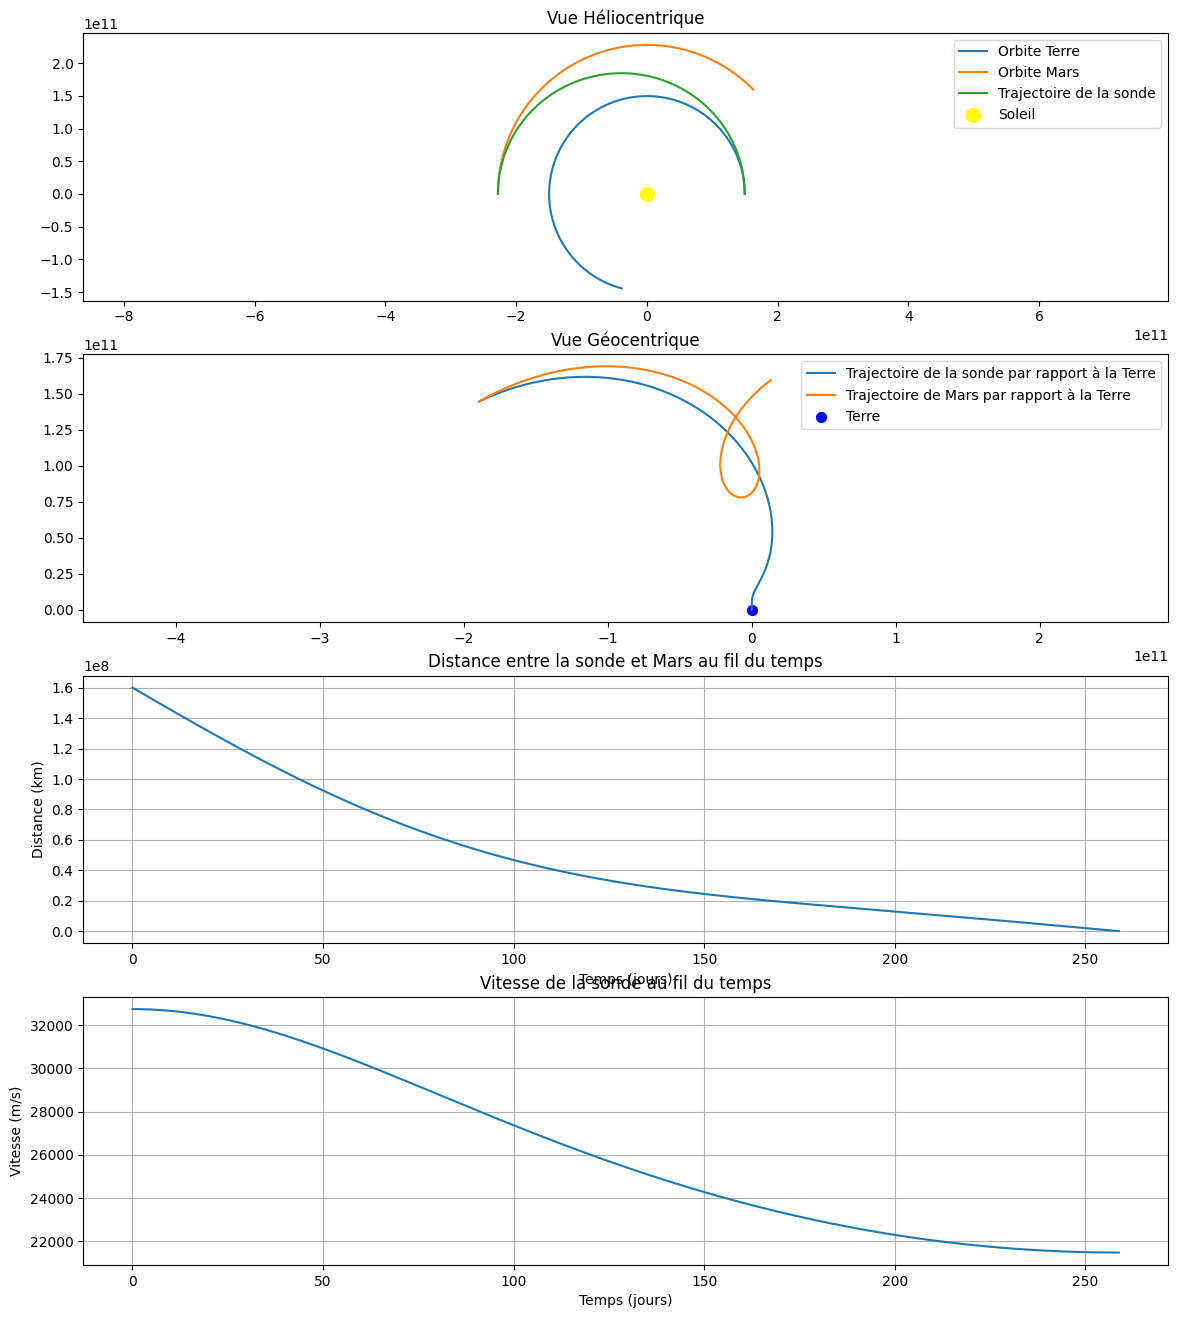

Position finale du vaisseau: [4.92553711e-02 5.39126380e+05]


In [9]:
duree = 280 * 24 * 3600  # durée totale de la simulation en secondes
dt = 3600  # pas en secondes
delta_v = vitesse_hohmann(distanceTerreSoleil, distanceMarsSoleil)  # Ajustement de la vitesse initiale
stop_distance = 500000  # Distance de Mars à laquelle la simulation s'arrete

def simuler_mission(duree, dt, delta_v, stop_distance=500000):
    num_etapes = int(duree / dt)
    etats = np.zeros((num_etapes, 4))  # x, y, vx, vy
    positions_terre = np.zeros((num_etapes, 2))
    positions_mars = np.zeros((num_etapes, 2))
    distances = np.zeros(num_etapes)
    vitesses = np.zeros(num_etapes)

    angle_phase = angle_phase_optimal()
    vitesse_initiale = delta_v + np.sqrt(G * mSoleil / distanceTerreSoleil)

    for i in range(num_etapes):
        t = i * dt
        etats[i] = [distanceTerreSoleil, 0, 0, vitesse_initiale] if i == 0 else rk4(t, etats[i-1], dt, derivees_heliocentrique)
        positions_terre[i] = [distanceTerreSoleil * np.cos(2 * np.pi * t / periodeTerre), distanceTerreSoleil * np.sin(2 * np.pi * t / periodeTerre)]
        positions_mars[i] = [distanceMarsSoleil * np.cos(2 * np.pi * t / periodeMars + angle_phase), distanceMarsSoleil * np.sin(2 * np.pi * t / periodeMars + angle_phase)]
        distances[i] = np.linalg.norm(etats[i, :2] - positions_mars[i]) - rayon_mars
        vitesses[i] = np.linalg.norm(etats[i, 2:4])
        if distances[i] <= stop_distance:
            days, remainder = divmod(i * dt, 86400)
            hours, remainder = divmod(remainder, 3600)
            minutes, seconds = divmod(remainder, 60)
            print(f"La sonde est à 500km de Mars au bout de: {days} jours, {hours} heures, {minutes} minutes, {seconds} secondes")
            num_etapes = i + 1  # Ajuste le nombre de pas pour arrêter à la distance spécifiée.
            break

    # Tronque les tableaux au nombre de pas réalisés.
    etats = etats[:num_etapes]
    positions_terre = positions_terre[:num_etapes]
    positions_mars = positions_mars[:num_etapes]
    distances = distances[:num_etapes]
    vitesses = vitesses[:num_etapes]

    # Plot des resultats, on definit une taille afin que tous les graph soient visibles
    plt.figure(figsize=(14, 16))

    # vue heliocentrique
    plt.subplot(4, 1, 1)
    plt.title("Vue Héliocentrique")
    plt.plot(positions_terre[:, 0], positions_terre[:, 1], label='Orbite Terre')
    plt.plot(positions_mars[:, 0], positions_mars[:, 1], label='Orbite Mars')
    plt.plot(etats[:, 0], etats[:, 1], label='Trajectoire de la sonde')
    plt.scatter([0], [0], color='yellow', s=100, label='Soleil')
    plt.legend()
    plt.axis('equal')

    # vue  Geocentrique
    plt.subplot(4, 1, 2)
    plt.title("Vue Géocentrique")
    plt.plot(etats[:, 0] - positions_terre[:, 0], etats[:, 1] - positions_terre[:, 1], label='Trajectoire de la sonde par rapport à la Terre')
    plt.plot(positions_mars[:, 0] - positions_terre[:, 0], positions_mars[:, 1] - positions_terre[:, 1], label='Trajectoire de Mars par rapport à la Terre')
    plt.scatter([0], [0], color='blue', s=50, label='Terre')
    plt.legend()
    plt.axis('equal')

    # Distance entre le vaisseau et Mars
    plt.subplot(4, 1, 3)
    plt.title("Distance entre la sonde et Mars au fil du temps")
    plt.xlabel("Temps (jours)")
    plt.ylabel("Distance (km)")
    plt.plot(np.arange(num_etapes) * dt / 86400, distances / 1000)
    plt.grid(True)

    # vitesse du vaisseau
    plt.subplot(4, 1, 4)
    plt.title("Vitesse de la sonde au fil du temps")
    plt.xlabel("Temps (jours)")
    plt.ylabel("Vitesse (m/s)")
    plt.plot(np.arange(num_etapes) * dt / 86400, vitesses)
    plt.grid(True)
    plt.show()

    # renvoie la position finale par rapport a Mars 
    return etats[-1, :2] - positions_mars[-1]


position_finale = simuler_mission(duree, dt, delta_v, stop_distance)
print("Position finale du vaisseau:", position_finale)


### Premiers résultats et commentaires:
* Le premier graphique montre que la sonde atteint bien sa destination. 
* Les deux autres graphiques confirment le succès de la mission puisque on peut voir que la distance entre la sonde et Mars atteind le $500 km$, cette distance est définie en fonction de missions deja réalisées.
* La durrée totale du voyage est $258$ jours et $19$ heures, ce qui correspond à la durrée moyenne des voyages Terre-Mars déjà réalisés, notamment la mission Curiosity qui à durée $253$ jours.
* Visuelement, la trajectoire du vaisseau ressemble aux trajectoires réelles.
* La compatibilité des résultats avec la realité justifient donc les approximations et hypotheses considérées.

## Deuxieme Partie :  Aterrissage sur Mars

Desormais nous sommes dans le referentiel de Mars. Notre but est de modeliser un aterrissage controlé afin que notre vaisseau ne s'ecrase pas sur Mars.



### Fonction `derivee_mars`

La fonction `derivee_mars` est utilisée pour donner les accélérations subit par la sonde qu'on intégrera ensuite grace à `rk4`. Elle calcule les forces gravitationnelles exercées par Mars et lui ajoute un freinage lorsque la sonde se trouve à une distance inférieur à la distance d_frein par rapport à Mars.


 **Accélération due à la gravité martienne (Newtonn)** : 
   
$$ ax = -G \frac{m_{Mars} x}{r^3},\quad ay = -G \frac{m_{Mars} y}{r^3} $$

**Freinage** :
   - Activé si $ ( r - \text{rayon_mars} < d_{frein} ) $
   - **Force de freinage** ajoutée à l'accélération de Mars grâce au "+=", ajustée en opposition à la direction de la vitesse et répartie sur x et y 
   grace à $\frac{v_{x/y}}{\| \mathbf{v} \|}$:
    
$$ ax += -\left(\frac{\text{force}}{m_{sonde}}\right) \frac{v_{x}}{\| \mathbf{v} \|}$$
$$ ay += -\left(\frac{\text{force}}{m_{sonde}}\right) \frac{v_{y}}{\| \mathbf{v} \|} $$
    
Pour ce qui est du freinage dans la vraie vie (pour une sonde d'environ d'une tonne):
  - L'Aérofreinage qui débute un peu après les 150km d'altitude correspond à une force de frein comprise entre 10 et 15 mille Newtonn
  - Le parachute dont l'ouverture débute à une dizaine de kilomètres correspond à une force de frein comprise entre 2 et 3 mille Newtonn
  - Les rétrofusées qui sont déclenchés à quelques kilomètres de la surface correspondent  à une force d'environ 12000 Newtonn

Donc en prenant  un freinage de 15000 Newtonn qui débute à 150km nous ne sommes pas loin de ce qui peut se faire en mission réelle.


In [10]:
def derivee_mars(t, etat, d_frein=150000, force=15000, masse_sonde=1000): #force est la force de freinage qui débute à d_frein

    x, y, vx, vy = etat
    r_carre = x**2 + y**2
    r = np.sqrt(r_carre )    #norme distance du vaiseau à mars
    ax = -G * mMars * x / r_carre **1.5
    ay = -G * mMars * y / r_carre **1.5
    
    # Décélération linéaire
    if r - rayon_mars < d_frein:
        v_norm = np.sqrt(vx**2 + vy**2)
        if v_norm != 0:  # Éviter la division par zéro
            ax += -(force/masse_sonde) * (vx/v_norm)
            ay += -(force/masse_sonde) * (vy/v_norm)
    
    return np.array([vx, vy, ax, ay])


### Fonction `orbite_mars`

Cette fonction prend en entrée la postion de la sonde par rapport à Mars (que `simuler_mission` retourne), le pas de temps pour l'intégratio et le moment ou je veux commencer l'atterrissage. Elle me retourne 3 graphiques montrant: la trajectoire de la sonde autour de mars, la vitesse de la sonde et son altitude. Elle m'indique également le temps au bout duquel la sonde touche Mars et à quelle vitesse elle le fait.

Les différentes étapes de la fonction sont:

**-Caclcul des grandeurs nécessaires pour l'orbitage** :
La vitesse orbitale pour une orbite circulaire est calculée par la formule :

$$ v_{orbite} = \sqrt{\frac{G \cdot m_{Mars}}{r_{init}}} $$ 
avec $r_{init}$: rayon de l'orbite qui est la norme de la position donnée en entrée

L'angle dans lequel appliquer $v_{orbite}$ afin de faire orbiter la sonde. Ce qui correspond à la tangente du cercle décrit par l'orbite au point de départ.

Ces deux étapes nous permettent d'avoir le vecteur vitesse nécessaire à la mise en orbite (v_init).

**-Initialisation**

**-Calcul des positions, de la vitesse et de l'altitude de la sonde jusqu'à t, début de l'aterrissage**

**-Vitesse mise à 0 pour initier l'atterissage**

**-Calcul des positions , de la vitesse et de l'altitude de la sonde qui continue et freinage grâce à`derivee_mars`** 

**-Print de la fin de la simulation ainsi que sa durée et la vitesse de la sonde lorsqu'elle touche Mars**

**-Différents plots pour les positions, la vitesse et l'altitude de la sonde**

La sonde a touché le sol de Mars à 1 heures, 10 minutes, 0 secondes avec une vitesse de 45.48 m/s.


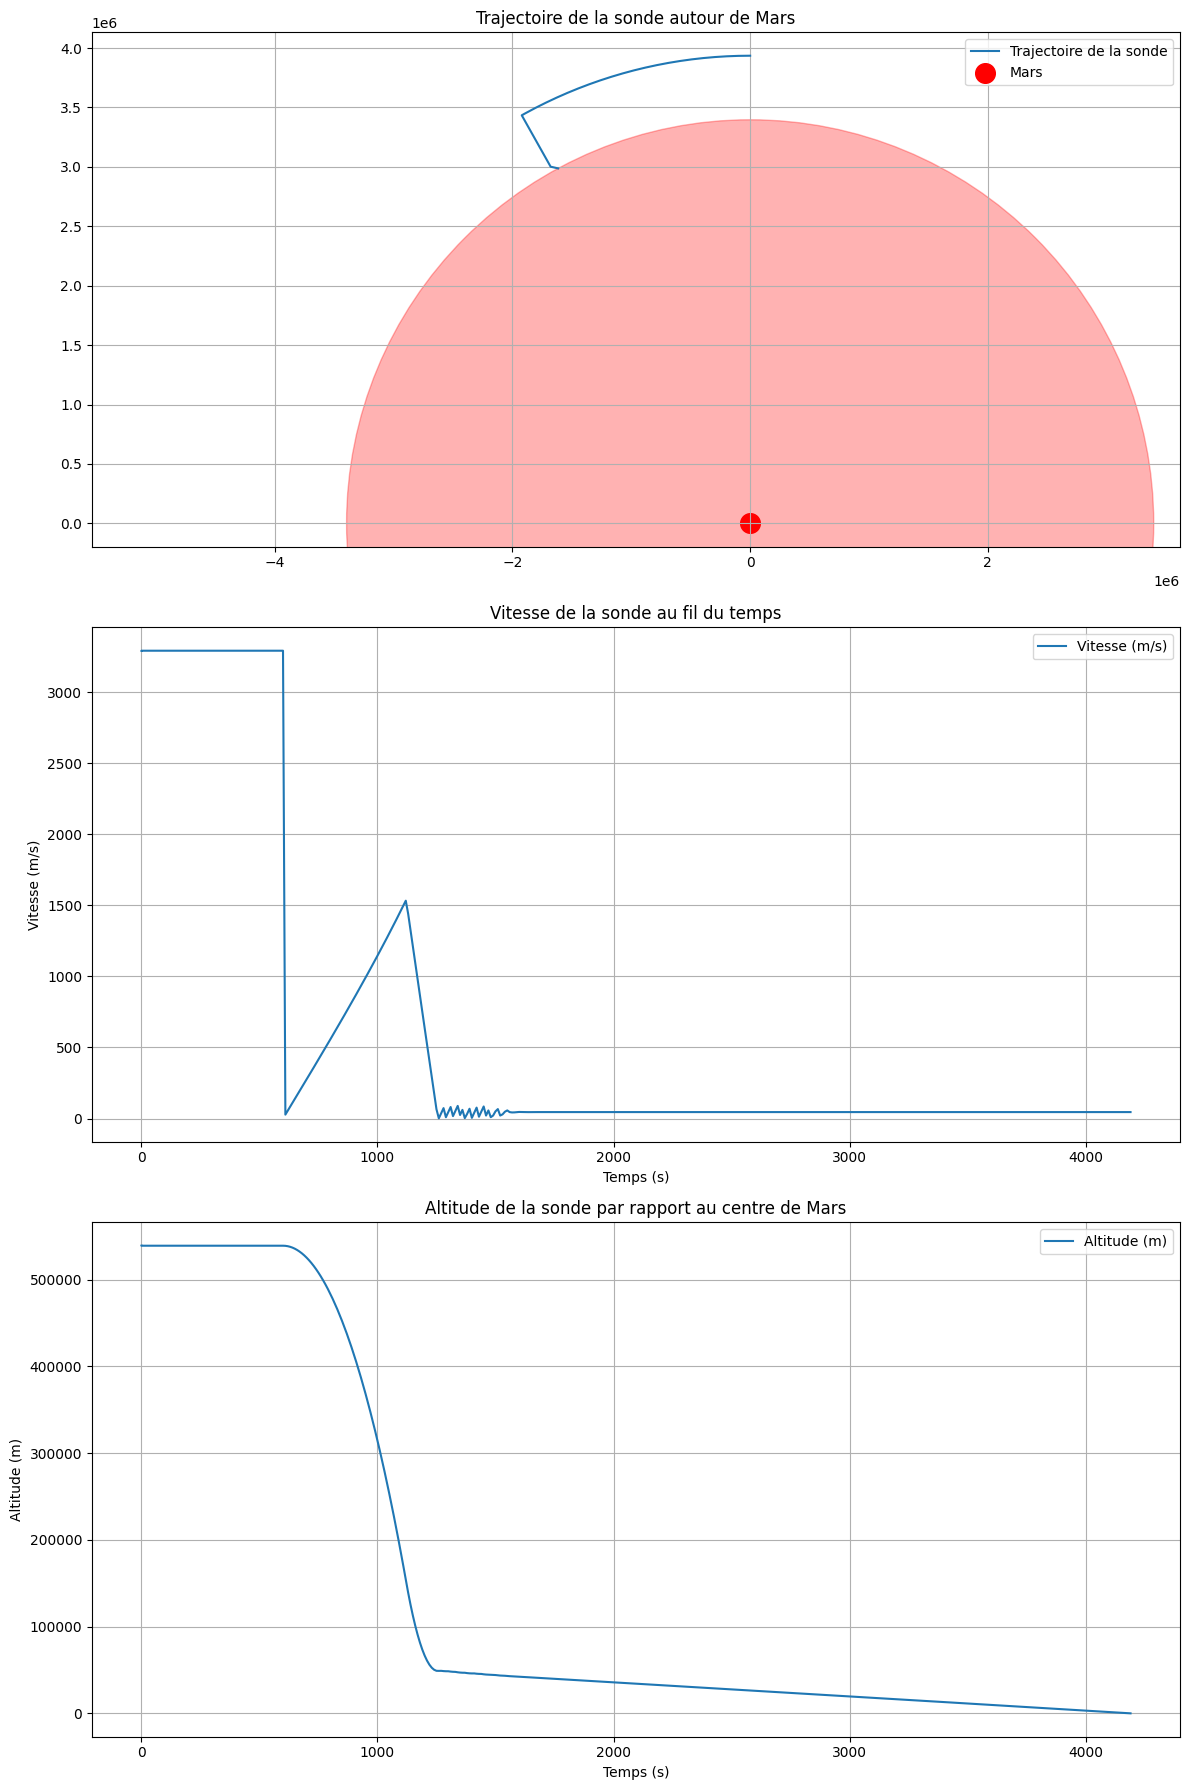

In [11]:
def orbite_mars(position_relative_mars, dt, temps_chute):


    # Convertir la position relative à la surface de Mars en position relative au centre de Mars
    position_initiale = [position_relative_mars[0], position_relative_mars[1] + rayon_mars]

    # Calcul de la vitesse orbitale initiale pour une orbite circulaire
    r_init = np.linalg.norm(position_initiale) #norme position initiale
    v_orbite = np.sqrt(G * mMars / r_init)
    theta = np.arctan2(position_initiale[1], position_initiale[0]) + np.pi/2
    v_init = np.array([np.cos(theta), np.sin(theta)]) * v_orbite

    # Définir l'état initial de la sonde
    etat = np.array([position_initiale[0], position_initiale[1], v_init[0], v_init[1]])
    trajet = [etat.copy()]
    vitesses = [np.linalg.norm(etat[2:])]
    altitudes = [np.linalg.norm(etat[:2]) - rayon_mars]
    t = 0
    times = [t]
    decel_start_time = None

    # Simulation jusqu'à la chute
    while t <= temps_chute:
        etat = rk4(t, etat, dt, derivee_mars)
        trajet.append(etat.copy())
        vitesses.append(np.linalg.norm(etat[2:]))
        altitudes.append(np.linalg.norm(etat[:2]) - rayon_mars)
        times.append(t)
        if decel_start_time is None and np.linalg.norm(etat[:2]) - rayon_mars < 150000:
            decel_start_time = t
        t += dt

    touch_down_time = t
    etat[2:] = 0  # Vitesse nulle pour initier la chute

    # Simulation de la chute sous gravité
    while np.linalg.norm(etat[:2]) > rayon_mars:
        etat = rk4(t, etat, dt, derivee_mars)
        trajet.append(etat.copy())
        vitesses.append(np.linalg.norm(etat[2:]))
        altitudes.append(np.linalg.norm(etat[:2]) - rayon_mars)
        times.append(t)
        t += dt

    final_speed = np.linalg.norm(etat[2:])  # Enregistrer vitesse finale

    # La sonde a touché le sol de Mars
    print(f"La sonde a touché le sol de Mars à {t//3600} heures, {(t%3600)//60} minutes, {t%60} secondes avec une vitesse de {final_speed:.2f} m/s.")

    trajet = np.array(trajet)
    vitesses = np.array(vitesses)
    altitudes = np.array(altitudes)
    times = np.array(times)


    # Visualisation de la trajectoire, vitesse, et altitude
    plt.figure(figsize=(12, 18))

    # Plot de la trajectoire
    plt.subplot(3, 1, 1)
    plt.title("Trajectoire de la sonde autour de Mars")
    plt.plot(trajet[:, 0], trajet[:, 1], label="Trajectoire de la sonde")
    plt.scatter([0], [0], color='red', s=200, label='Mars')
    circle = plt.Circle((0, 0), rayon_mars, color='red', fill=True, alpha=0.3)
    plt.gca().add_artist(circle)
    plt.axis('equal')
    plt.legend()
    plt.grid(True)

    # Plot de la vitesse
    plt.subplot(3, 1, 2)
    plt.title("Vitesse de la sonde au fil du temps")
    plt.plot(times, vitesses, label="Vitesse (m/s)")
    if decel_start_time is not None:
        decel_start_index = np.argmin(np.abs(times - decel_start_time))
        plt.scatter([decel_start_time], [vitesses[decel_start_index]], color='blue', label="Début de la décélération")
    plt.xlabel("Temps (s)")
    plt.ylabel("Vitesse (m/s)")
    plt.legend()
    plt.grid(True)

    # Plot de l'altitude
    plt.subplot(3, 1, 3)
    plt.title("Altitude de la sonde par rapport au centre de Mars")
    plt.plot(times, altitudes, label="Altitude (m)")
    plt.xlabel("Temps (s)")
    plt.ylabel("Altitude (m)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

orbite_mars(position_finale, 10, 600)

### Deuxièmes résultats et commentaires:
* On a un atterissage assez contolé sur Mars. La sonde atteint sa destination.
* Le temps passé en orbite dépend de l'endroit où l'on souhaite atterir, ici nous ne visons pas de cratère précis donc on peut mettre un temps en orbite faible ( 10 minutes).
* La vitesses finales est légerement trop rapide, la precision de notre code ne nous permet pas de modeliser exactement l'aterrissage et les forces subies par le parachute ou les aerofreins.

# Conclusion:

#### Notre vaisseau atteint la planete Mars en 258 jours, 20 heures et 10 minutes. Notre projet a modéliser avec succès le trajet d'un vaisseau de la Terre à Mars. Les résultats des simulations ont validé la précision de notre modèle par rapport aux données de missions réelles. Nous sommes prêtes à <span style="color:red;"> COLONISER MARS</span> .

### Bibliographie :
 - Cours de l'UE Physique Numérique

 - [Mission habitée vers Mars](https://fr.wikipedia.org/wiki/Mission_habit%C3%A9e_vers_Mars)

 - [Exploration de Mars par Curiosity](https://fr.wikipedia.org/wiki/Exploration_de_Mars_par_Curiosity)

 - [Curiosity : comprendre la mission du rover sur Mars](https://www.numerama.com/sciences/1066096-curiosity-rover-nasa-tout-comprendre-mission-mars-science-laboratory.html)
   
 - [Stack Overflow](https://stackoverflow.com/)